In [1]:
#%matplotlib
import healpy as hp
import matplotlib.pyplot as plt
import healsparse as hs
import fitsio
import numpy as np
import sys

In [2]:
print(hs.__version__)

1.6.0


In [3]:
import skyproj #if this doesn't work, check if correct env has been activated

In [4]:
resol_4096 = hp.nside2resol(4096, arcmin=True)
areapx_4096 = resol_4096*resol_4096
print(areapx_4096,'arcmin squared')
resol_16384 = hp.nside2resol(16384, arcmin=True)
areapx_16384 = resol_16384*resol_16384
print(areapx_16384,'arcmin squared')

0.7376604303613772 arcmin squared
0.046103776897586074 arcmin squared


In [5]:
datadir = '/afs/ciemat.es/user/s/sevilla/data/masks/'
filename_sh = datadir+'y6-combined-hleda-gaiafull-des-stars-hsmap16384-nomdet-v3.fits' #shear catalog footprint
filename_cl = datadir+'y6a2_foreground_mask_v1.3.fits.gz' #foreground mask, cl stands for clustering
filename_foot = datadir+'y6a2_footprint_v2.0.hs' #nominal DES footprint from Gold
filename_lss = datadir+'Y6LSSBAO_V2_MASK_WITHDEPTH_up_to_22.2.fits.gz' #maglim mask, current lss default for 3x2

In [9]:
footprint = hs.HealSparseMap.read(filename_foot, 32) #nominal footprint of DES 
mask_goldfore = hs.HealSparseMap.read(filename_cl, 32) #note that this file contains the areas to be masked out, not a footprint
footprint_sh = hs.HealSparseMap.read(filename_sh, 32) #shear footprint, after the masking defined by the WLWG
# we create a modified version of the footprint, where we will apply subsequent cuts based on the foregrounds
footprint_sel = hs.HealSparseMap.read(filename_foot, 32) #we will make the cuts here, to keep the footprint untouched

In [6]:
# the maglim footprint is not in healpix format
mask_lss = fitsio.read(filename_lss,ext=1)['HPIX_4096'].ravel() #this creates a numpy array with the valid pixels in the LSS footprint

In [7]:
# with these commands I create a healsparse map for the maglim footprint
footprint_lss = hs.HealSparseMap.make_empty(32, 4096, dtype = np.int32, primary='I')
footprint_lss[mask_lss] = 1 #maglim footprint

In [10]:
#set all values with footprint > 0 to 1 in new footprint_sel
footprint_sel[footprint.valid_pixels[footprint.get_values_pix(footprint.valid_pixels) > 0]] = 1.0
#set all values with footprint == 0 (which were observed but do not meet footprint requirements) to UNSEEN in new footprint_sel
footprint_sel[footprint.valid_pixels[footprint.get_values_pix(footprint.valid_pixels) == 0]] = hp.UNSEEN
#mask out regions from foreground mask
footprint_sel[mask_goldfore.valid_pixels[mask_goldfore.get_values_pix(mask_goldfore.valid_pixels) > 0]] = hp.UNSEEN

In [13]:
#create an AND map (intersection) of the maglim and shear footprints. This will take a few seconds to minutes.
sum_intersection = hs.operations.sum_intersection([footprint_lss.upgrade(16384), footprint_sh])

In [15]:
#create an AND map (union) of the Gold masked footprint and -shear footprint, to check the area being lost
sum_intersection_goldforexsh = hs.operations.sum_intersection([footprint_sel.upgrade(16384), footprint_sh])

In [14]:
#create an OR map (union) of the Gold masked footprint and -shear footprint, to plot where the differences are
footprint_sh *= (-1)
sum_union = hs.operations.sum_union([footprint_sel.upgrade(16384), footprint_sh])

In [78]:
#create a map with areas in the shear footprint AND NOT in the Gold masked footprint
footprint_sh_sel = hs.HealSparseMap.read(filename_sh, 32) #reload shear footprint in a different variable
footprint_sh_sel[footprint_lss.upgrade(16384).valid_pixels] = 0 #set all pixels in the shear footprint present in the Gold masked footprint, to 2 (didn't manage to set to sentinel value for integer map)

In [79]:
validpx_foot_sh_sel = len(footprint_sh_sel.valid_pixels[footprint_sh_sel.get_values_pix(footprint_sh_sel.valid_pixels) == 1])
print(areapx_16384*validpx_foot_sh_sel/3600.,'sq.deg. in shear footprint, but not in LSS footprint, no fracdet')

194.4736454357188 sq.deg. in shear footprint, but not in LSS footprint, no fracdet


In [77]:
import copy
footprint_lss_sel = copy.deepcopy(footprint_lss) #making a fresh copy of the maglim footprint
footprint_lss_sel = footprint_lss_sel.upgrade(16384)
footprint_lss_sel[footprint_sh.valid_pixels] = 0 #set all pixels in the maglim footprint present in the shear one to 0
validpx_foot_lss_sel = len(footprint_lss_sel.valid_pixels[footprint_lss_sel.get_values_pix(footprint_lss_sel.valid_pixels) == 1])
print(areapx_16384*validpx_foot_lss_sel/3600.,'sq.deg. in LSS footprint, but not in shear footprint, no fracdet')

177.2362756830165 sq.deg. in LSS footprint, but not in shear footprint, no fracdet


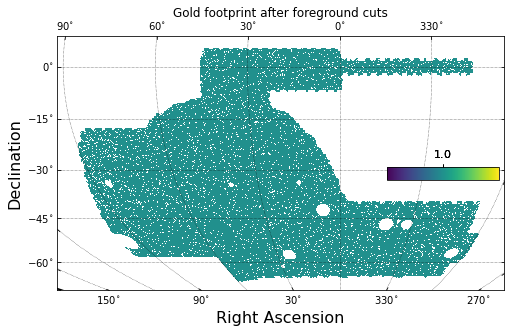

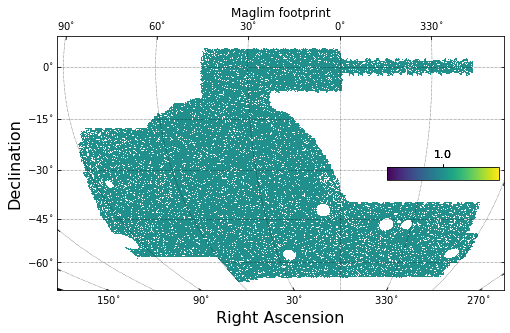

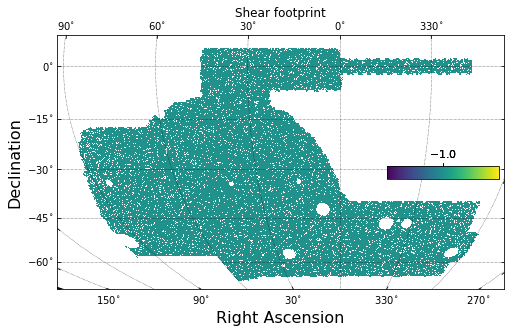

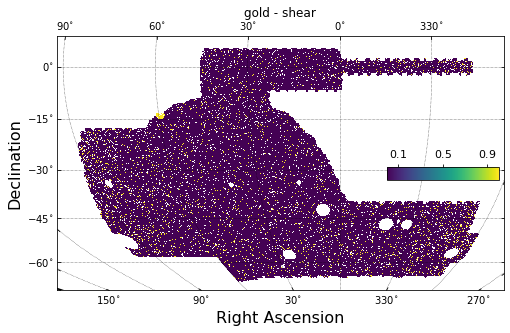

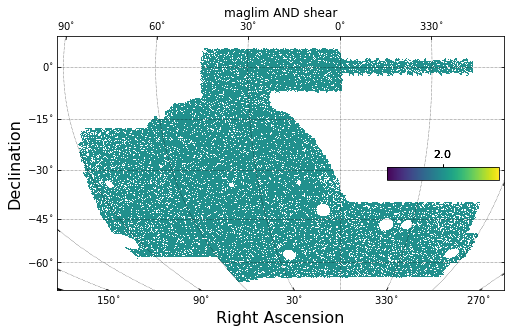

In [16]:
#make a bunch of nice skyproj maps of the different footprints
fig = plt.figure(1, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
_ = sp.draw_hspmap(footprint_sel)
sp.draw_inset_colorbar()
plt.title('Gold footprint after foreground cuts',y = 1.05)
plt.show()

fig = plt.figure(1, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
_ = sp.draw_hspmap(footprint_lss)
sp.draw_inset_colorbar()
plt.title('Maglim footprint',y = 1.05)
plt.show()

fig = plt.figure(1, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
_ = sp.draw_hspmap(footprint_sh)
sp.draw_inset_colorbar()
plt.title('Shear footprint',y = 1.05)
plt.show()

fig = plt.figure(1, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
_ = sp.draw_hspmap(sum_union)
sp.draw_inset_colorbar()
plt.title('gold - shear',y = 1.05)
plt.show()

fig = plt.figure(1, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
_ = sp.draw_hspmap(sum_intersection)
sp.draw_inset_colorbar()
plt.title('maglim AND shear',y = 1.05)
plt.show()

In [17]:
#let's count and store the number of pixels of each footprint, to calculate the total area
validpx_foot = len(footprint.valid_pixels)
validpx_foot_sel = len(footprint_sel.valid_pixels)
validpx_sh = len(footprint_sh.valid_pixels)
validpx_lss = len(footprint_lss.valid_pixels)
validpx_shxlss = len(sum_intersection.valid_pixels)
validpx_shxgold = len(sum_intersection_goldforexsh.valid_pixels)

In [18]:
print(areapx_4096*validpx_foot/3600.,'sq.deg. complete DR2 area with no fracdet')
print(areapx_4096*validpx_foot_sel/3600.,'sq.deg. gold foreground masked footprint, no fracdet')
#print(areapx_4096*np.sum(footprint_sel.get_values_pix(footprint_sel.valid_pixels))/3600.,'sq.deg. masked footprint with fracdet')
print(areapx_16384*validpx_sh/3600.,'sq.deg. shear footprint, no fracdet')
print(areapx_4096*validpx_lss/3600.,'sq.deg. maglim footprint, no fracdet')
print(areapx_16384*validpx_shxlss/3600.,'sq.deg. maglim x shear, no fracdet')
print(areapx_16384*validpx_shxgold/3600.,'sq.deg. gold masked x shear, no fracdet')

5171.73625273524 sq.deg. complete DR2 area with no fracdet
4538.966217835048 sq.deg. foreground masked footprint, no fracdet
4435.515784199026 sq.deg. shear footprint, no fracdet
4418.278414446323 sq.deg. maglim footprint, no fracdet
4241.042138763307 sq.deg. maglim x shear, no fracdet
4357.2374620650835 sq.deg. gold masked x shear, no fracdet


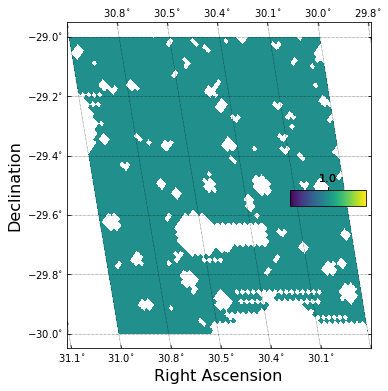

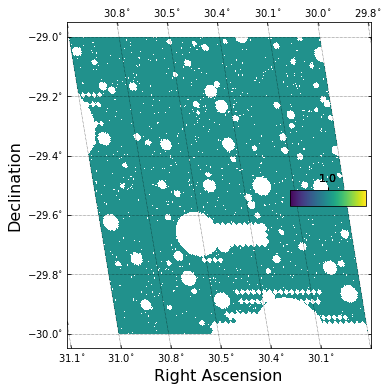

In [47]:
#plt.ion()
fig = plt.figure(1, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(footprint_sel,lon_range=[30,31],lat_range=[-30,-29])
sp.draw_inset_colorbar()
plt.show()
fig = plt.figure(1, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(footprint_sh,lon_range=[30,31],lat_range=[-30,-29])
sp.draw_inset_colorbar()
plt.show()

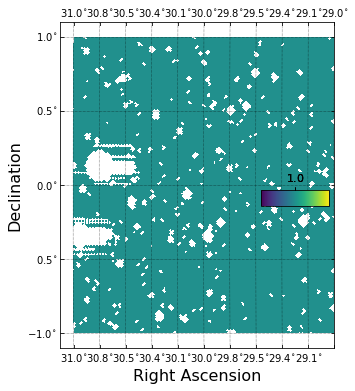

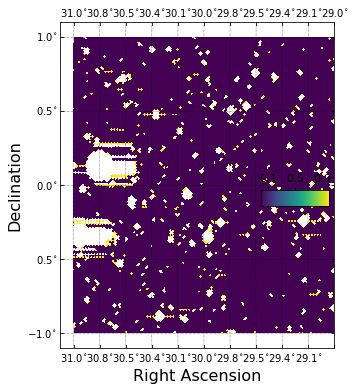

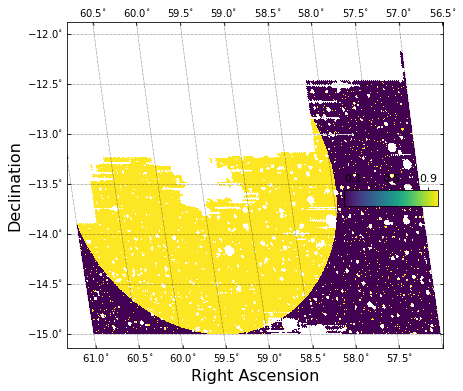

In [84]:
fig = plt.figure(1, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(footprint_sel,lon_range=[29,31],lat_range=[-1,1])
sp.draw_inset_colorbar()
plt.show()

fig = plt.figure(1, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(footprint_sh_sel,lon_range=[29,31],lat_range=[-1,1])
sp.draw_inset_colorbar()
plt.show()

fig = plt.figure(1, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(footprint_lss_sel,lon_range=[57,61],lat_range=[-15,-11])
sp.draw_inset_colorbar()
plt.show()